# Housing Prices Competition for Kaggle Learn Users
## Competition Description

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

## Goal

It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

## Metric

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [477]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel

from category_encoders import SumEncoder, OrdinalEncoder

In [306]:
def save_submission(X, pred):
    pd.DataFrame({'SalePrice': pred}, index=X['Id']).to_csv('submission.csv')

In [307]:
df = pd.read_csv('data/train.csv')
df.shape

(1460, 81)

In [308]:
df_submission = pd.read_csv('data/test.csv')
df_submission.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Data cleaning
All information about handling the data is provided in 'exploratory_analysis.ipynb'.

Filter unwanted outliers

In [309]:
df_filtered_outliers = df[((df['LotFrontage'] < 250) | df['LotFrontage'].isna()) &
                           (df['LotArea'] < 100000) &
                           (df['MasVnrArea'] < 1200) &
                           (df['BsmtFinSF1'] < 5000) &
                           (df['BsmtFinSF2'] < 1400) &
                           (df['TotalBsmtSF'] < 6000) &
                           (df['BsmtFinSF1'] < 5000) &
                           (df['1stFlrSF'] < 4000) &
                           (df['2ndFlrSF'] < 2000) &
                           (df['GrLivArea'] < 4500) &
                           (df['BedroomAbvGr'] < 7) &
                           (df['KitchenAbvGr'].isin([1, 2])) &
                           (df['WoodDeckSF'] < 700) &
                           (df['OpenPorchSF'] < 450) &
                           (df['EnclosedPorch'] < 350)]
df_filtered_outliers.shape

(1429, 81)

Drop broken elements
1. Drop element that has 'BsmtCond' but missed 'BsmtExposure'.
1. Drop element that has 'BsmtFinType1' but missed 'BsmtFinType2'.

In [310]:
drop_mask = ~(df_filtered_outliers['BsmtExposure'].isna() ^ df_filtered_outliers['BsmtCond'].isna() |
              df_filtered_outliers['BsmtFinType2'].isna() ^ df_filtered_outliers['BsmtFinType1'].isna())
df_droped_broken = df_filtered_outliers[drop_mask]
df_droped_broken.shape

(1427, 81)

Handle missing data and endode categorical data

In [311]:
num_transformer = Pipeline([('impute', SimpleImputer(strategy='mean')),
                            ('scaler', StandardScaler())])
cat_transformer = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value='No')),
                            ('encode', OneHotEncoder(handle_unknown='ignore'))])

Generate 'BsmtFinPer' feature.

In [312]:
class BsmtFinPerGenerator(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame({'BsmtFinPer': 1 - X['BsmtUnfSF'] / X['TotalBsmtSF']}).fillna(0)

In [313]:
bsmt_generator = Pipeline([('generate', BsmtFinPerGenerator()),
                           ('scaler', StandardScaler())])

Build final data transformation pipeline.

In [314]:
num_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal']
cat_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
                'SaleCondition']
bsmt_features = ['BsmtUnfSF', 'TotalBsmtSF']

In [315]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features),
                                  ('bsmt', bsmt_generator, bsmt_features)])

# Baseline
Build the baseline for SGD regression. The target metric is LogRMSE.

Split the data for train and holdout subsets.

In [316]:
X = df_droped_broken.drop('SalePrice', axis='columns')
y = df_droped_broken['SalePrice']
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2)
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape

((1141, 80), (286, 80), (1141,), (286,))

Build the baseline.

In [317]:
class SGDRegressorPositive(SGDRegressor):
    
    def predict(self, X, **predict_params):
        pred = super().predict(X, **predict_params)
        pred[pred < 0] = 0
        return pred

In [366]:
estimator = SGDRegressorPositive()
baseline = Pipeline([('preprocessing', preprocessor),
                     ('estimator', estimator)])

In [367]:
baseline.fit(X_train, y_train)
baseline_predictions = baseline.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, baseline_predictions))

0.1279629321471858

In [368]:
baseline.fit(X, y)
save_submission(df_test, baseline.predict(df_test))

## SVD
Try to decrease dimensionality.

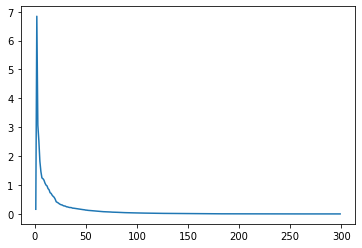

In [370]:
svd = TruncatedSVD(n_components=299)
svd.fit(preprocessor.transform(X))
plt.plot(np.linspace(1, 299, 299), svd.explained_variance_)
plt.show()

In [393]:
svd_model = Pipeline([('preprocessing', preprocessor),
                      ('svd', TruncatedSVD(n_components=200)),
                      ('estimator', estimator)])

In [396]:
svd_model.fit(X_train, y_train)
svd_pred = svd_model.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, svd_pred))

0.13139829185126572

In [397]:
svd_model.fit(X, y)
save_submission(df_test, svd_model.predict(df_test))

## Random Forest

In [455]:
num_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal']
cat_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
                'SaleCondition']
bsmt_features = ['BsmtUnfSF', 'TotalBsmtSF']

In [456]:
num_transformer = Pipeline([('impute', SimpleImputer(strategy='mean', fill_value=0)),
                            ('scaler', StandardScaler())])
cat_transformer = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value='No')),
                            ('encode', OneHotEncoder(handle_unknown='ignore'))])
bsmt_generator = Pipeline([('generate', BsmtFinPerGenerator()),
                           ('scaler', StandardScaler())])

In [457]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features),
                                  ('bsmt', bsmt_generator, bsmt_features)])

In [412]:
estimator = RandomForestRegressor(n_estimators=300)
rf_model = Pipeline([('preprocessing', preprocessor),
                     ('estimator', estimator)])

In [413]:
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, rf_pred))

0.13015199740679587

In [414]:
rf_model.fit(X, y)
save_submission(df_test, rf_model.predict(df_test))

The random forest did not show significant performance improvement.

## Gradient Boosting

In [416]:
estimator = GradientBoostingRegressor()
gb_model = Pipeline([('preprocessing', preprocessor),
                     ('estimator', estimator)])

In [417]:
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, gb_pred))

0.12329010594179454

In [418]:
gb_model.fit(X, y)
save_submission(df_test, gb_model.predict(df_test))

Tuning gradient boosting parameters

In [419]:
param_grid = {'estimator__learning_rate': [0.05, 0.1, 0.2],
              'estimator__n_estimators': [50, 100, 200],
              'estimator__subsample': [0.6, 0.8, 1.0],
              'estimator__min_samples_split': [8, 4, 2],
              'estimator__min_samples_leaf': [4, 2, 1],
              'estimator__max_depth': [8, 3, 2],
              'estimator__max_features': ['sqrt', 'log2', 'auto']}

gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid=param_grid,
                       scoring='neg_mean_squared_log_error',
                       n_jobs=-1,
                       cv=3,
                       verbose=True)
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 27.6min
[Parallel(n_jobs=-1)]: Done 6561 out of 6561 | elapsed: 28.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('impute',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [420]:
gb_grid.best_score_, gb_grid.best_params_

(-0.01500460382431218,
 {'estimator__learning_rate': 0.1,
  'estimator__max_depth': 3,
  'estimator__max_features': 'auto',
  'estimator__min_samples_leaf': 4,
  'estimator__min_samples_split': 2,
  'estimator__n_estimators': 200,
  'estimator__subsample': 0.6})

In [421]:
gb_grid.best_estimator_.fit(X_train, y_train)
gb_pred = gb_grid.best_estimator_.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, gb_pred))

0.11797622874332905

In [422]:
gb_grid.best_estimator_.fit(X, y)
save_submission(df_test, gb_grid.best_estimator_.predict(df_test))

Try to tune number of estimators.

In [424]:
estimator = GradientBoostingRegressor(max_features='auto',
                                      min_samples_leaf=4,
                                      subsample=0.6)
gb_model = Pipeline([('preprocessing', preprocessor),
                     ('estimator', estimator)])

In [425]:
param_grid = {'estimator__n_estimators': [200, 250, 300, 350, 400],
              'estimator__subsample': [0.3, 0.4, 0.5, 0.6]}

gb_grid = GridSearchCV(estimator=gb_model,
                       param_grid=param_grid,
                       scoring='neg_mean_squared_log_error',
                       n_jobs=-1,
                       cv=3,
                       verbose=True)
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   34.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessing',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('impute',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [426]:
gb_grid.best_score_, gb_grid.best_params_

(-0.014747543479791887,
 {'estimator__n_estimators': 250, 'estimator__subsample': 0.5})

In [427]:
gb_grid.best_estimator_.fit(X_train, y_train)
gb_pred = gb_grid.best_estimator_.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, gb_pred))

0.11743419650429188

In [428]:
gb_grid.best_estimator_.fit(X, y)
save_submission(df_test, gb_grid.best_estimator_.predict(df_test))

## Additional feature engineering
First, try to select features.

In [503]:
num_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
                'MasVnrArea', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
                'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal']
cat_features = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
                'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
                'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
                'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
                'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
                'SaleCondition']
bsmt_features = ['BsmtUnfSF', 'TotalBsmtSF']

In [504]:
num_transformer = Pipeline([('impute', SimpleImputer(strategy='mean', fill_value=0)),
                            ('scaler', StandardScaler())])
cat_transformer = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value='No')),
                            ('encode', OneHotEncoder(handle_unknown='ignore'))])
bsmt_generator = Pipeline([('generate', BsmtFinPerGenerator()),
                           ('scaler', StandardScaler())])

In [505]:
preprocessor = ColumnTransformer([('num', num_transformer, num_features),
                                  ('cat', cat_transformer, cat_features),
                                  ('bsmt', bsmt_generator, bsmt_features)])

In [506]:
estimator = GradientBoostingRegressor(n_estimators=200,
                                      learning_rate=0.1,
                                      max_depth=3,
                                      max_features='auto',
                                      min_samples_leaf=4,
                                      min_samples_split=2,
                                      subsample=0.6)
gb_model = Pipeline([('preprocessing', preprocessor),
                     ('estimator', estimator)])

In [507]:
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_holdout)
np.sqrt(mean_squared_log_error(y_holdout, gb_pred))

0.11967428085513684

In [502]:
gb_model.fit(X, y)
save_submission(df_test, gb_model.predict(df_test))